In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spotify-million-song-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2660706%2F4558658%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T142600Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4136f1cad3f836ebdb3e8fc607d5834ceab182eec5ab86a6fb2920a679ae4543d5316aea9d6ebbc2ff4b97d9428032eb3df41b9446d59d1c321827aefb5df810d276e8bf312d9f421b5b4272fc70c04a0824026837793de77485cb47fc5479fd5ecf077f40db05a4f255b1304e5606684502c74a1a1ec182c316d09ef576be580876b918dbc6f883e441749882fa4187f741cf6d534a98c5c2f65f6620139194f2d1310b50509bfc9a51370b8e57f68f10a91996ecba1de68f3a20b8b4441b685f6252fa84060c23e3e16554109350c36b75d77cdff6ba9dceedafae5e6c2fdd37e906d9cf71f16b99fb925781bacd8936586f854c7e8e872e2014d1351682e6,new-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4775672%2F8089462%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T142600Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fd9fc41faf7d29fd2f78c7285e0331337ad68a0beae5af6d257d3643916b0e57f0ada6ede9ea4f747b58f26d195b340ce2ecb2b561fb7347f1b22000ff2c9cfa9e7a488b25111907aa263f994abda7955383cb767dbe67b6068644266399500447c497a1414fb3175f82a277ac5640e6c8bd62783ee01c389c8dc07ebe5cba212d223d7b77d198ca2c9852c386f1a5380fb7bafddb32951150894ffd5924d0e9133e2932271f9062d9806bda09c3d8e220cf44b58d2b5c785f6a8d5ee4110885063dc5f4f7ce064eb2e70abf2846ad98286b1c6ab1ba4fd9fff119d78c0b6784a4ed753e09bea144ee781a7fdcff1fee93f0d45133bdba3dfa14b03fba53467,wp-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4775729%2F8089534%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T142600Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e4c8ee7065426e8364a3aaaa3fd685c8c072ad195b7de1492b574b004ec8b2a4ca3eed06aab9bac81485cd2b6632de7f8c1996693ebbc5e81f780303c32f97fa1d5044914d94533a27bec1e8409ed20caf4179d5e276e26237fbbfea2c3fbd49cd3d4106b101cbe1539bbab6316c4ba60db9414c365c76b5a3df1583bceb8419ad27a15fd4916df75ce7efb23b252396f0dc7e80207ad5f3582190d5be0f4ae085753e026422cd780380f91e927177cf8b715210a02260395f00ed0d0531c0420967034d86335e539b1754502e5b7b56cef1a340d852a6289cd245f2a34928d4907d34a8d5113ed0e4ad7efe091e398b4676ec94dfe86d7e8ed8a108535968b,embeddings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4779081%2F8094418%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T142600Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc381dec1e30f329cb11e72b9ef3b49812b85a88328eafada920c07a56550922250e50469cd12d300350b5dc1c6ac19950bdd3691c6a14b32436ab0c66a6c446dc1913e41352d31387f446708b367b3670b19b7d5d0ffba7559169b92436133b8592b5820ef8a814e6b02a97608282c9614ea876c0fa4cd2476e4929157bfb0f24271da2bbfcb3653c5f8acc7f12aa55d288791393d82af7e7380ffb759f07a11e0ce87459a7ac4571154b6c8cd557722aa47f3dbff5e4fca7747028f6e189939f7dcf35708b38fb70553b941c7b526566b0afe561f5e554e47dcbce4cbf9a025b1d82799875cde651cc20dddd705a52aa24b6925bde259066f933b2585c3f162,model-folder:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4783039%2F8099712%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T142600Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D063c21adddfad8c17b302a5e113ac887d4977021beb6da6f6a76cd1d32d7b2555b2b2c330de4532e300e4f57fffa08819e51e8edfbe4b38659c0a895eadcd1bfa4ae0860bb4ae4ac2a595a373e81897f40fc5649b3706063ceac53a5e30b84a1f8f45ef4076668853f4d04b15ab954d98898fbfe089e22cef95550479bc7e717963b9ae36ca8f4eea9bba7e27f874f62bdadc49f2758aa644af8da118b1c5ee32c1a56e56dc2b7585b33bc55afd9d825e915cd69d89d5419daa97fc18ed5ccda4e16eff6c46bf0d9390debf9ce56f9179b9dca4452d9227cd76ad6f18572716e99176f5b2e2052c57bd07ff66ff5feffd6c5238ab33bb3aaf0d17679a55ab8b6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
from torch.utils.data import random_split
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Speech to Text

## Loading the DataSet

In [ ]:
train_url = "train-clean-100"
test_url = "test-clean"
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url=train_url, download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url=test_url, download=True)

## Waveforms and Spectrograms

In [ ]:
def plot_audio_waveform_mel_spectrogram(audio, sample_rate):
    # Plot waveform
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio, sr=sample_rate)
    plt.title('Waveform')

    # Plot mel spectrogram
    plt.subplot(2, 1, 2)
    mel_spec = librosa.feature.melspectrogram(y=audio[0], sr=sample_rate, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(log_mel_spec, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

In [ ]:
audio , sample_rate , text , start_time , end_time , _ = train_dataset[0]
print(text)
ipd.Audio(data=audio[0], rate=16000)

CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK


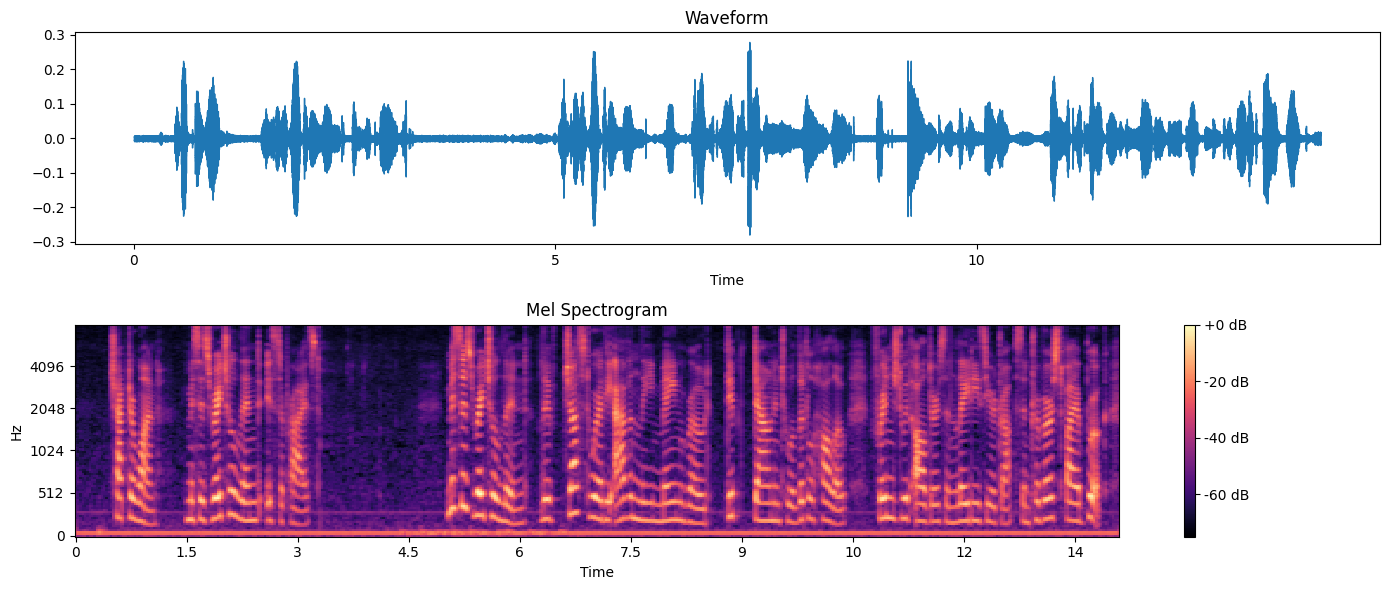

In [ ]:
plot_audio_waveform_mel_spectrogram(np.array(audio) , sample_rate)

In [ ]:
use_cuda = torch.cuda.is_available()

## Data Processing

In [ ]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

In [ ]:
learning_rate = 5e-4
batch_size = 10
epochs = 10
hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

In [ ]:
def average_wer(wer_scores , combined_ref_len): # For finding average word error rate
    return float(sum(wer_scores))/float(combined_ref_len)

In [ ]:
def _levenshtein_distance(ref, hyp):
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]

In [ ]:
def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)

In [ ]:
def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

In [ ]:

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer

In [ ]:

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
class Text_Transform:
    def __init__(self):
        self.char_map = {
            "'": 0,
            '<SPACE>': 1,
            'a': 2,
            'b': 3,
            'c': 4,
            'd': 5,
            'e': 6,
            'f': 7,
            'g': 8,
            'h': 9,
            'i': 10,
            'j': 11,
            'k': 12,
            'l': 13,
            'm': 14,
            'n': 15,
            'o': 16,
            'p': 17,
            'q': 18,
            'r': 19,
            's': 20,
            't': 21,
            'u': 22,
            'v': 23,
            'w': 24,
            'x': 25,
            'y': 26,
            'z': 27
        }
        self.index_map = {
            0: "'",
            1: ' ',
            2: 'a',
            3: 'b',
            4: 'c',
            5: 'd',
            6: 'e',
            7: 'f',
            8: 'g',
            9: 'h',
            10: 'i',
            11: 'j',
            12: 'k',
            13: 'l',
            14: 'm',
            15: 'n',
            16: 'o',
            17: 'p',
            18: 'q',
            19: 'r',
            20: 's',
            21: 't',
            22: 'u',
            23: 'v',
            24: 'w',
            25: 'x',
            26: 'y',
            27: 'z'
        }

    def text_to_int(self, text):
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = Text_Transform()


In [ ]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)

valid_loader = data.DataLoader(dataset=valid_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

In [ ]:
torch.cuda.is_available()

True

## Models

### Training and Testing Functions

In [ ]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)
    train_loss = 0
    losses = []
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
#         print(output.shape)
        output = F.log_softmax(output, dim=2)

        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))

    losses = np.array(losses)
    return model , losses



In [ ]:
def test(model, device, test_loader, criterion, data_type = "valid"):
    print('\nevaluating...')
#     count = 0
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
#     with experiment.test():
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)

            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print( data_type ,'set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    return test_loss , avg_cer , avg_wer


In [ ]:
import librosa
import torchaudio
def get_prediction( model , file ) :

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_transform = Text_Transform()
    waveform ,sr = librosa.load( file , sr = 16000 , mono = True )
    waveform = waveform.reshape( 1 , -1)
    waveform = torch.tensor(waveform)
    valid_audio_transforms = torchaudio.transforms.MelSpectrogram()
    spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
    spectrograms = [[spec]]
    spectrograms = [spec]  # Wrap spec tensor in a list
    padded_spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
    padded_spectrograms = padded_spectrograms.unsqueeze(1).transpose(2, 3)
    padded_spectrograms = padded_spectrograms.to(device)
    model.eval()
    output = model(padded_spectrograms)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1)
    arg_maxes = torch.argmax(output.transpose(0, 1) , dim = 2 )
    decodes = []
    for i , args in enumerate(arg_maxes):
        decode = []
        for j , index in enumerate(args):
            if(index != 28 ):
                if(j !=0 and index == args[j-1]):
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes

### Implementation of CNN , ResCNN and Bidirectional GRU

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


In [ ]:
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

### Model1 - CNN--> BiGRU

#### Model Architecture

In [ ]:
class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
#         x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

#### Model Training

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

In [ ]:
training_loss = []
validation_loss = []
avg_cer_validation = []
avg_wer_validation = []
for epoch in range(1 , 6 ):
    model , loss_epoch = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
    training_loss.append(loss_epoch)
    test_loss , avg_cer , avg_wer = test(model, device, valid_loader, criterion, "Validation")
    validation_loss.append(test_loss)
    avg_cer_validation.append(avg_cer)
    avg_wer_validation.append(avg_wer)
    print("-------------------------------------------------------------------------")

Train Epoch: 1 [0/25685 (0%)]	Loss: 7.990340
Train Epoch: 1 [1000/25685 (4%)]	Loss: 2.950949
Train Epoch: 1 [2000/25685 (8%)]	Loss: 2.882667
Train Epoch: 1 [3000/25685 (12%)]	Loss: 2.864426
Train Epoch: 1 [4000/25685 (16%)]	Loss: 2.882652
Train Epoch: 1 [5000/25685 (19%)]	Loss: 2.876090
Train Epoch: 1 [6000/25685 (23%)]	Loss: 2.858905
Train Epoch: 1 [7000/25685 (27%)]	Loss: 2.892544
Train Epoch: 1 [8000/25685 (31%)]	Loss: 2.904486
Train Epoch: 1 [9000/25685 (35%)]	Loss: 2.854058
Train Epoch: 1 [10000/25685 (39%)]	Loss: 2.892094
Train Epoch: 1 [11000/25685 (43%)]	Loss: 2.876569
Train Epoch: 1 [12000/25685 (47%)]	Loss: 2.810168
Train Epoch: 1 [13000/25685 (51%)]	Loss: 2.857189
Train Epoch: 1 [14000/25685 (54%)]	Loss: 2.852840
Train Epoch: 1 [15000/25685 (58%)]	Loss: 2.815523
Train Epoch: 1 [16000/25685 (62%)]	Loss: 2.747669
Train Epoch: 1 [17000/25685 (66%)]	Loss: 2.550853
Train Epoch: 1 [18000/25685 (70%)]	Loss: 2.503220
Train Epoch: 1 [19000/25685 (74%)]	Loss: 2.307412
Train Epoch: 1 [

In [ ]:
torch.save(model, 'model_cnn_bigru.pth')

In [ ]:
test(model, device, test_loader, criterion, "Test" )


evaluating...
Test set: Average loss: 0.8122, Average CER: 0.248778 Average WER: 0.6823



(0.8122232469893599, 0.24877828741937144, 0.6823334955548708)

In [ ]:
model.eval()
test_loss = 0
test_cer, test_wer = [], []

with torch.no_grad():
    for i, _data in enumerate(test_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() / len(test_loader)
        print('----------------------------------------------------')
        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
        for j in range(len(decoded_preds)):

            print(decoded_targets[j])
            print(decoded_preds[j])
            print('-----------------------------------------------------')
        break

----------------------------------------------------
he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
he hoped there would be stoom fordinner turnips and carit send brosed be taehos and fat mutn peces to be laele doutanfick pepered fouwer fetan ses
-----------------------------------------------------
stuff it into you his belly counselled him
stuffid into you his belly counsald him
-----------------------------------------------------
after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels
after erly night fall the en aw lamps wild lihte hop pear in there the squalled corter of the brofls
-----------------------------------------------------
hello bertie any good in your mind
n a berty an e glood in hemind
-----------------------------------------------------
number ten fresh nelly is waiting on you good night husband
nom bec de

Actual Speech --> "Hello , suggest me a sad song"

Predicted Speech --> "a ok sethis made no tedso"

In [ ]:
pred_given_voice = get_prediction(model , '/kaggle/input/test-audio/test_audio.flac' )
print(pred_given_voice)

['a ok sethis made no tedso']


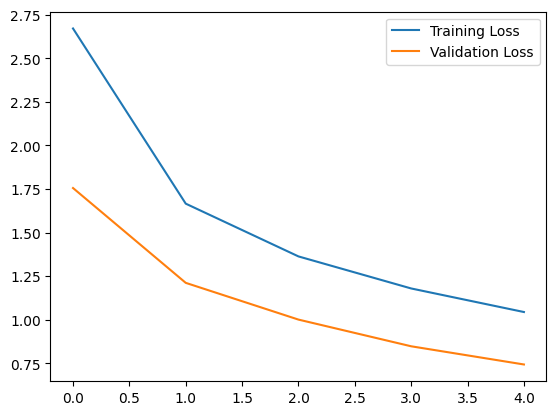

In [ ]:
import matplotlib.pyplot as plt
losses = []
for i in training_loss:
    losses.append(i.mean())
plt.plot(losses , label = "Training Loss")
plt.plot(validation_loss , label = "Validation Loss")
plt.legend()
plt.show()

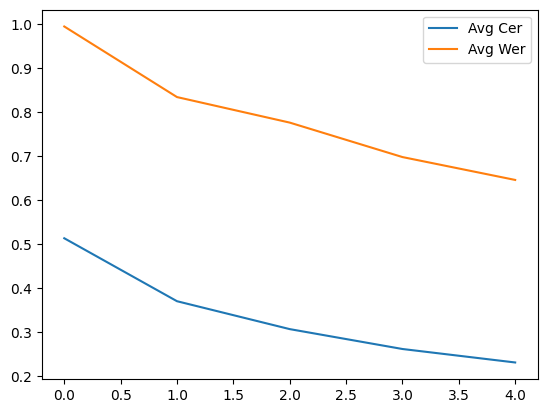

In [ ]:
plt.plot(avg_cer_validation , label = "Avg Cer")
plt.plot(avg_wer_validation , label = "Avg Wer")
plt.legend()
plt.show()

### Model 2 - Introduction Res CNN Layers

##### Model Architecture

In [ ]:
class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

##### Model Training

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
    ).to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

In [ ]:
training_loss = []
validation_loss = []
avg_cer_validation = []
avg_wer_validation = []
for epoch in range(1 , 6 ):
    model , loss_epoch = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
    training_loss.append(loss_epoch)
    test_loss , avg_cer , avg_wer = test(model, device, valid_loader, criterion, "Validation")
    validation_loss.append(test_loss)
    avg_cer_validation.append(avg_cer)
    avg_wer_validation.append(avg_wer)
    print("-------------------------------------------------------------------------")

Train Epoch: 1 [0/23116 (0%)]	Loss: 6.795219

Train Epoch: 1 [1000/23116 (4%)]	Loss: 2.949335

Train Epoch: 1 [2000/23116 (9%)]	Loss: 2.881650

Train Epoch: 1 [3000/23116 (13%)]	Loss: 2.882793

Train Epoch: 1 [4000/23116 (17%)]	Loss: 2.880684

Train Epoch: 1 [5000/23116 (22%)]	Loss: 2.854017

Train Epoch: 1 [6000/23116 (26%)]	Loss: 2.886934

Train Epoch: 1 [7000/23116 (30%)]	Loss: 2.856039

Train Epoch: 1 [8000/23116 (35%)]	Loss: 2.876811

Train Epoch: 1 [9000/23116 (39%)]	Loss: 2.846146

Train Epoch: 1 [10000/23116 (43%)]	Loss: 2.833673

Train Epoch: 1 [11000/23116 (48%)]	Loss: 2.871658

Train Epoch: 1 [12000/23116 (52%)]	Loss: 2.875174

Train Epoch: 1 [13000/23116 (56%)]	Loss: 2.869740

Train Epoch: 1 [14000/23116 (61%)]	Loss: 2.830574

Train Epoch: 1 [15000/23116 (65%)]	Loss: 2.833142

Train Epoch: 1 [16000/23116 (69%)]	Loss: 2.764155

Train Epoch: 1 [17000/23116 (74%)]	Loss: 2.412009

Train Epoch: 1 [18000/23116 (78%)]	Loss: 2.312741

Train Epoch: 1 [19000/23116 (82%)]	Loss: 2.1663

In [ ]:
torch.save(model, 'model_1.pth')

In [ ]:
test(model, device, test_loader, criterion, "Test" )



evaluating...

Test set: Average loss: 0.7208, Average CER: 0.218342 Average WER: 0.6035




(0.7207906303059967, 0.21834184918349456, 0.6034663878285889)

In [ ]:
model.eval()
test_loss = 0
test_cer, test_wer = [], []

with torch.no_grad():
    for i, _data in enumerate(test_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() / len(test_loader)
        print('----------------------------------------------------')
        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
        for j in range(len(decoded_preds)):

            print(decoded_targets[j])
            print(decoded_preds[j])
            print('-----------------------------------------------------')
        break


----------------------------------------------------

he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce

he hoped ther would be stoo her diner turnips and carrict sand brused betat hos and tat mut en peaces to be latled out an t fic pepered fhouer facon sas 

-----------------------------------------------------

stuff it into you his belly counselled him

stuffid into you his belly countild him

-----------------------------------------------------

after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels

after early night fall the enlow lamps would liht hap her an ther the squilled quarter of the brofils

-----------------------------------------------------

hello bertie any good in your mind

her i berityy and he good ing yr mind

-----------------------------------------------------

number ten fresh nelly is waiting on you g

In [ ]:
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=hparams['epochs'],
                                        anneal_strategy='linear')

In [ ]:

for epoch in range(6 ,11 ):
    model , loss_epoch = train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
    training_loss.append(loss_epoch)
    test_loss , avg_cer , avg_wer = test(model, device, valid_loader, criterion, "Validation")
    validation_loss.append(test_loss)
    avg_cer_validation.append(avg_cer)
    avg_wer_validation.append(avg_wer)
    print("-------------------------------------------------------------------------")

Train Epoch: 6 [0/23116 (0%)]	Loss: 0.746804

Train Epoch: 6 [1000/23116 (4%)]	Loss: 0.943102

Train Epoch: 6 [2000/23116 (9%)]	Loss: 0.815374

Train Epoch: 6 [3000/23116 (13%)]	Loss: 0.981711

Train Epoch: 6 [4000/23116 (17%)]	Loss: 0.825134

Train Epoch: 6 [5000/23116 (22%)]	Loss: 0.869051

Train Epoch: 6 [6000/23116 (26%)]	Loss: 0.819487

Train Epoch: 6 [7000/23116 (30%)]	Loss: 0.927505

Train Epoch: 6 [8000/23116 (35%)]	Loss: 0.707042

Train Epoch: 6 [9000/23116 (39%)]	Loss: 0.955151

Train Epoch: 6 [10000/23116 (43%)]	Loss: 0.917130

Train Epoch: 6 [11000/23116 (48%)]	Loss: 0.682738

Train Epoch: 6 [12000/23116 (52%)]	Loss: 0.802629

Train Epoch: 6 [13000/23116 (56%)]	Loss: 0.765581

Train Epoch: 6 [14000/23116 (61%)]	Loss: 0.956140

Train Epoch: 6 [15000/23116 (65%)]	Loss: 0.994248

Train Epoch: 6 [16000/23116 (69%)]	Loss: 0.687622

Train Epoch: 6 [17000/23116 (74%)]	Loss: 0.871236

Train Epoch: 6 [18000/23116 (78%)]	Loss: 0.848931

Train Epoch: 6 [19000/23116 (82%)]	Loss: 0.7521

In [ ]:
torch.save(model, 'model_2.pth')

In [ ]:
model.eval()
test_loss = 0
test_cer, test_wer = [], []

with torch.no_grad():
    for i, _data in enumerate(test_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        output = model(spectrograms)  # (batch, time, n_class)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        test_loss += loss.item() / len(test_loader)
        print('----------------------------------------------------')
        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
        for j in range(len(decoded_preds)):

            print(decoded_targets[j])
            print(decoded_preds[j])
            print('-----------------------------------------------------')
        break


----------------------------------------------------

he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce

he hoped there would be sto her dinner turnips and caratsand brosed petatos and tat buten pieaces to be latled outinth thic peppered flowr facan saus

-----------------------------------------------------

stuff it into you his belly counselled him

stuffid in to you his belly counstiled him

-----------------------------------------------------

after early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels

after early night fall the yelnlow lamps would light hap phere ind there the squalled quarter of the brofls

-----------------------------------------------------

hello bertie any good in your mind

hor i've berty and a good in yur mind

-----------------------------------------------------

number ten fresh nelly is waiting on 

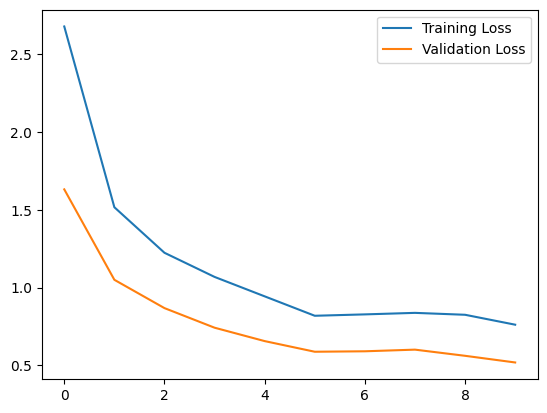

In [ ]:
import matplotlib.pyplot as plt
losses = []
for i in training_loss:
    losses.append(i.mean())
plt.plot(losses , label = "Training Loss")
plt.plot(validation_loss , label = "Validation Loss")
plt.legend()
plt.show()

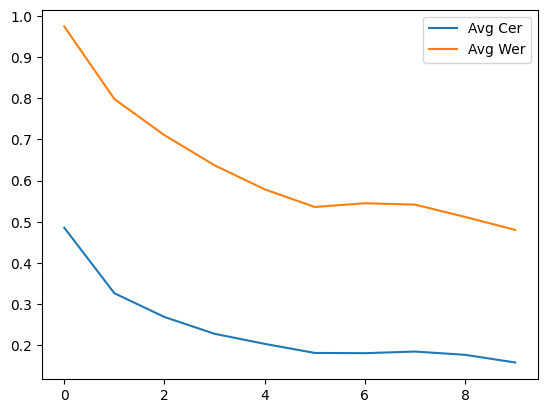

In [ ]:
plt.plot(avg_cer_validation , label = "Avg Cer")
plt.plot(avg_wer_validation , label = "Avg Wer")
plt.legend()
plt.show()

# Recommendation

In [ ]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 33.2 MB/s eta 0:00:00


In [ ]:
pip install fuzzywuzzy

In [ ]:
import string
import re
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss
import os
from tqdm import tqdm
from pprint import pprint
import numpy as np

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

In [ ]:
songs_data = pd.read_csv("/kaggle/input/spotify-million-song-dataset/spotify_millsongdata.csv")
songs_data.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
def cleanString(sentence):
    sentence = sentence.translate(str.maketrans("","", string.punctuation)).strip().lower()
    sentence = re.sub(r"https?://\s+", "", sentence)
    sentence = re.sub(r"\b\d+\b",  "", sentence)
    sentence = re.sub(r" +"," ",sentence).replace("\n", " ").replace("\r", "").replace("\r\n", "")
    sentence = re.sub("\s+", " ", sentence)
    return sentence

In [ ]:
songs_data["prepText"] = songs_data["text"].apply(cleanString)

songs_data = songs_data[["artist", "song", "prepText"]]
songs_data["allText"] = songs_data["artist"]+" "+songs_data["song"] + " "+songs_data["prepText"]
songs_data.head()

,artist,song,prepText,allText
0,ABBA,Ahe's My Kind Of Girl,look at her face its a wonderful face and it m...,ABBA Ahe's My Kind Of Girl look at her face it...
1,ABBA,"Andante, Andante",take it easy with me please touch me gently li...,"ABBA Andante, Andante take it easy with me ple..."
2,ABBA,As Good As New,ill never know why i had to go why i had to pu...,ABBA As Good As New ill never know why i had t...
3,ABBA,Bang,making somebody happy is a question of give an...,ABBA Bang making somebody happy is a question ...
4,ABBA,Bang-A-Boomerang,making somebody happy is a question of give an...,ABBA Bang-A-Boomerang making somebody happy is...


In [ ]:
class ClosestArtist:
    def __init__(self, df , query):
        self.df = df
        self.vectorizer = TfidfVectorizer()
        self.tfid_matrix = self.vectorizer.fit_transform(self.df['artist'])
        self.query = query

    def recommend_artist(self):
        artist_match, artist_score, _ = process.extractOne(self.query, self.df['artist'])

        idx = self.df[self.df['artist'] == artist_match].index[0]

        artist_list = self.df[self.df['artist']==artist_match]['song'].tolist()
        return artist_match, artist_list, artist_score


In [ ]:

transformer_model = 'all-MiniLM-L6-v2'


In [ ]:
class findEmbedding:
    def __init__(self , df ) :
        self.df = df
        self.model = SentenceTransformer(transformer_model)
        self.embeddings = self.computeEmbeddings()


    def computeEmbeddings(self):
        sentences = self.df["allText"].values
        embeddings = []
        for sentence in tqdm(sentences):
            embeddings.append(self.model.encode(sentence))

        return np.array(embeddings)



In [ ]:
class ClosestSong:
    def __init__(self, df , query):
        self.df = df
        self.vectorizer = TfidfVectorizer()
        self.tfid_matrix = self.vectorizer.fit_transform(self.df['song'])
        self.query = query

    def recommend_song(self):
        song_match, song_score, _ = process.extractOne(self.query, self.df['song'])

        idx = self.df[self.df['song'] == song_match].index[0]

        song_list = self.df[self.df['song']==song_match]['song'].tolist()
        return song_match , song_list , song_score


In [ ]:
class recmmSystem:
    def __init__(self , embeddings , df ) -> None:
        self.model = SentenceTransformer(transformer_model)
        self.df = df
        self.embeddings = embeddings
        dimension = embeddings.shape[1]
        quantize = faiss.IndexFlatL2(dimension)
        self.index = faiss.IndexIVFFlat(quantize, dimension, 50)

        if not self.index.is_trained:
            self.index.train(embeddings)

        if self.index.is_trained:
            self.index.add(embeddings)

        print("Total Number of embeddings index {}".format(self.index.ntotal))

    def nearestNeighbour(self, query, k):
        queryEmbeddings = self.model.encode([query])
        print(f"Dimensionality of query embeddings: {queryEmbeddings.shape[1]}")

        D, I = self.index.search(queryEmbeddings, k)

        close_artist = ClosestArtist(self.df , query )
        artist, artist_list, artist_score = close_artist.recommend_artist()

        closest_song = ClosestSong(self.df , query )
        song , song_list , song_score = closest_song.recommend_song()

        recommendation = { 'artist' : None , 'songs' : [] , 'closest_song' : None}
        if(artist_score >= 50 ):
            recommendation['artist'] = artist
        if(song_score >= 50):
            recommendation['closest_song'] = song
        allRelatable = self.df.iloc[I[0]]

        for index , rows in allRelatable.iterrows():
            recommendation['songs'].append(rows['song'])

        return recommendation


In [ ]:
embeding_find = findEmbedding(songs_data)

In [ ]:
embeddings = embeding_find.embeddings

In [ ]:
embeddings.shape

(60, 384)

In [ ]:
with open( './embedding.npy', "wb") as fp:
          np.save(fp, embeddings)

In [ ]:
embeddings = np.load('/kaggle/input/embeddings/embedding.npy')

In [ ]:
embeddings

array([[-0.05798921, -0.05003113,  0.06517456, ..., -0.00979358,
        -0.02478648, -0.05705372],
       [-0.0637671 , -0.05309675,  0.04782454, ...,  0.01353788,
         0.07200279, -0.08234741],
       [-0.11482854, -0.09890363,  0.07630156, ...,  0.0045761 ,
        -0.02689303, -0.01882326],
       ...,
       [-0.10733505, -0.06675289,  0.02207662, ..., -0.0521297 ,
         0.0260805 , -0.07806736],
       [-0.01902047,  0.03850682,  0.00697991, ..., -0.04523466,
        -0.03747365, -0.04571009],
       [-0.08263505, -0.00092937,  0.09351958, ...,  0.06011732,
         0.02418889, -0.09896568]], dtype=float32)

In [ ]:
embeddings.shape

(57650, 384)

In [ ]:
rcSystem = recmmSystem(embeddings , songs_data)

Total Number of embeddings index 57650


In [ ]:
model = torch.load('/kaggle/input/model-folder/model_2.pth')

In [ ]:
file_path = '/kaggle/input/new-audio/test_audio.flac'
query = get_prediction(model , file_path)[0]
print("Actual Query :  'Suggest Me a Sad Song' " )
print(f"Predicted Query by Speech Model : {query}")
recommendations = rcSystem.nearestNeighbour(query, 4 )
print("Recommendations : ")
print("Closest Artist Recommendation : " , recommendations['artist'] )
print("Songs Recommended : " , recommendations['songs'])
print("Top Song Recommended : " , recommendations['closest_song'])

Actual Query :  'Suggest Me a Sad Song' 
Predicted Query by Speech Model : a lent sa wist me a saiso
Dimensionality of query embeddings: 384
Recommendations : 
Closest Artist Recommendation :  O.A.R.
Songs Recommended :  ['Raat Barasaat Ki, Pahali Mulaaqaat Ki', 'Nu Ma Las De Limba Noastra', 'Malia', 'Sore Tugu Pancoran']
Top Song Recommended :  Bang-A-Boomerang


In [ ]:
file_path = 'happy_nation.mp4'
query = get_prediction(model , file_path)[0]
print("Actual Query :  'happy nation' " )
print(f"Predicted Query by Speech Model : {query}")
recommendations = rcSystem.nearestNeighbour(query, 4 )
print("Recommendations : ")
print("Closest Artist Recommendation : " , recommendations['artist'] )
print("Songs Recommended : " , recommendations['songs'])
print("Top Song Recommended : " , recommendations['closest_song'])

Actual Query :  'happy nation' 
Predicted Query by Speech Model : hed penastion
Dimensionality of query embeddings: 384
Recommendations : 
Closest Artist Recommendation :  Sting
Songs Recommended :  ['He-O', 'Shiek', 'Skeletal Dance', 'Assassing']
Top Song Recommended :  He


In [ ]:
file_path = '/bang.mp4'
query = get_prediction(model , file_path)[0]
print("Actual Query :  'Bang' " )
print(f"Predicted Query by Speech Model : {query}")
recommendations = rcSystem.nearestNeighbour(query, 4 )
print("Recommendations : ")
print("Closest Artist Recommendation : " , recommendations['artist'] )
print("Songs Recommended : " , recommendations['songs'])
print("Top Song Recommended : " , recommendations['closest_song'])

Actual Query :  'Bang' 
Predicted Query by Speech Model : nbhang
Dimensionality of query embeddings: 384
Recommendations : 
Closest Artist Recommendation :  Zac Brown Band
Songs Recommended :  ['Mystery Babylon', 'Noctural Pleasure', 'The Villagers', 'Daffodils']
Top Song Recommended :  A!
